# Training U-Net model
## 250 Epochs, No Dropout, Adam Optimizer, Learning Rate 1e-3

In [1]:
import sys
sys.path.append("..")
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from src import data,unet

Using TensorFlow backend.


In [2]:
from keras import utils
train_dir = "/home/ubuntu/TrainingSet"
weight_file = 'saved_models/endo_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5'
epi_weight_file = 'saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5'
save_imgs_dir = 'images/train250NoDrpAdam3PWLoss/endo_images'
save_imgs_dir_epi = 'images/train250NoDrpAdam3PWLoss/epi_images'

images = []
inner_masks = []
outer_masks = []

patient_directories = sorted(glob.glob(os.path.join(train_dir, "patient*")))

for patient_dir in patient_directories:
    imgdata = data.ImageData(patient_dir)
    images += imgdata.labeled_images
    inner_masks += imgdata.endo_masks
    outer_masks += imgdata.epi_masks

images = np.asarray(images)[:,:,:,None].astype('float64')
i_masks = np.asarray(inner_masks)
o_masks = np.asarray(outer_masks)

dims = i_masks.shape
classes = len(set(i_masks[0].flatten()))
new_shape = dims + (classes,)
i_masks = utils.to_categorical(i_masks).reshape(new_shape)
o_masks = utils.to_categorical(o_masks).reshape(new_shape)

#i_masks_cropped=[]
#crop_x = 8

#for mask in i_masks:
#    i_masks_cropped.append(mask[0+crop_x//2:216-crop_x//2,:,:])

#print(i_masks[0].shape)
#print(i_masks_cropped[0].shape)

#i_masks_final = np.asarray(i_masks_cropped)



def normalize(x, epsilon=1e-7, axis=(1,2)):
    x -= np.mean(x, axis=axis, keepdims=True)
    x /= np.std(x, axis=axis, keepdims=True) + epsilon
    
normalize(images,axis=(1,2))

print("There are %d total training images." % len(images))
print("There are %d total inner masks." % len(inner_masks))
print("There are %d total outer masks." % len(outer_masks))

There are 243 total training images.
There are 243 total inner masks.
There are 243 total outer masks.


In [3]:
height,width,_ = images[0].shape
dropout = 0.0
unet_conv = unet.UNet()

model_endo = unet_conv.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model_endo.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 216, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 216, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 216, 256, 32) 0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
from keras.optimizers import Adam, SGD
from keras import backend as K

def dice_coef(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.round(K.flatten(y_pred))
    intersection = K.sum(flat_y_true * flat_y_pred)
    return (2. * intersection + 1.) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + 1.)

def dice_coef_np(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (np.sum(y_true) + np.sum(y_pred) + 1.)


def pixelwise_crossentropy(y_true, y_pred, weights=[0.5,0.5], epsilon=1e-8):
    ndim = K.ndim(y_pred)
    ncategory = K.int_shape(y_pred)[-1]
    # scale predictions so class probabilities of each pixel sum to 1
    y_pred /= K.sum(y_pred, axis=(ndim-1), keepdims=True)
    y_pred = K.clip(y_pred, epsilon, 1-epsilon)
    w = K.constant(weights) * (ncategory / sum(weights))
    # first, average over all axis except classes
    cross_entropies = -K.mean(y_true * K.log(y_pred), axis=tuple(range(ndim-1)))
    return K.sum(w * cross_entropies)


def show_plots(history):    
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.imshow()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.imshow()
    plt.savefig(os.path.join(save_imgs_dir,"acc-loss-plot.png"))
model_endo.compile(optimizer=Adam(lr=1e-3),loss=[pixelwise_crossentropy],metrics=[dice_coef])

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from math import ceil

seed = 78

validation_split = 0.2

epochs = 250
batch_size = 32


split_index = int((1 - validation_split) * len(images))

train_steps = ceil(split_index / batch_size)
val_steps = ceil((len(images)-split_index )/batch_size)

train_images = images[:split_index]
train_inner_masks = i_masks[:split_index]
train_outer_masks = o_masks[:split_index]

validation_images = images[split_index:]
validation_inner_masks = i_masks[split_index:]
validation_outer_masks = o_masks[split_index:]


data_gen_args = dict(rotation_range=180,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.01,
                     fill_mode='nearest')

train_images_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**data_gen_args)


#seed = 1
#height,width,channels = train_images[0].shape
#print(train_images[0].shape)
#print(train_inner_masks[0].shape)
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_inner_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_inner_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [6]:
checkpointer = ModelCheckpoint(filepath=weight_file, verbose=1, save_best_only=True)

hist = model_endo.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer],
                   validation_data=(validation_images,validation_inner_masks),validation_steps=val_steps)

Epoch 1/250
6/7 [========================>.....] - ETA: 2s - loss: 0.5805 - dice_coef: 0.7996
Epoch 00001: val_loss improved from inf to 0.19353, saving model to saved_models/endo_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 19s 3s/step - loss: 0.5192 - dice_coef: 0.8234 - val_loss: 0.1935 - val_dice_coef: 0.9593
Epoch 2/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1898 - dice_coef: 0.9483
Epoch 00002: val_loss improved from 0.19353 to 0.15083, saving model to saved_models/endo_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.1900 - dice_coef: 0.9470 - val_loss: 0.1508 - val_dice_coef: 0.9593
Epoch 3/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1629 - dice_coef: 0.9486
Epoch 00003: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.1712 - dice_coef: 0.9433 - val_loss: 0.1509 - val_dice_coef: 0.9593
Epoch 4/250
6/7 [==

Epoch 26/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1059 - dice_coef: 0.9486
Epoch 00026: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.1083 - dice_coef: 0.9469 - val_loss: 0.1183 - val_dice_coef: 0.9412
Epoch 27/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1117 - dice_coef: 0.9483
Epoch 00027: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.1115 - dice_coef: 0.9511 - val_loss: 0.1085 - val_dice_coef: 0.9555
Epoch 28/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1099 - dice_coef: 0.9513
Epoch 00028: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.1006 - dice_coef: 0.9557 - val_loss: 0.1072 - val_dice_coef: 0.9521
Epoch 29/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1072 - dice_coef: 0.9501
Epoch 00029: val_loss improved from 0.10190 to 0.10162, saving model to saved_models/endo_models/weights-250Epochs-NoDrop-

Epoch 54/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0827 - dice_coef: 0.9665
Epoch 00054: val_loss improved from 0.07760 to 0.07716, saving model to saved_models/endo_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.0783 - dice_coef: 0.9678 - val_loss: 0.0772 - val_dice_coef: 0.9700
Epoch 55/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0815 - dice_coef: 0.9663
Epoch 00055: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0834 - dice_coef: 0.9646 - val_loss: 0.1073 - val_dice_coef: 0.9640
Epoch 56/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0832 - dice_coef: 0.9664
Epoch 00056: val_loss improved from 0.07716 to 0.06989, saving model to saved_models/endo_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.0799 - dice_coef: 0.9691 - val_loss: 0.0699 - val_dice_coef: 0.9732
Epoch 57/250


Epoch 84/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0579 - dice_coef: 0.9771
Epoch 00084: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0567 - dice_coef: 0.9774 - val_loss: 0.0717 - val_dice_coef: 0.9733
Epoch 85/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0532 - dice_coef: 0.9789
Epoch 00085: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0496 - dice_coef: 0.9805 - val_loss: 0.0734 - val_dice_coef: 0.9746
Epoch 86/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0513 - dice_coef: 0.9796
Epoch 00086: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0523 - dice_coef: 0.9789 - val_loss: 0.0639 - val_dice_coef: 0.9754
Epoch 87/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0538 - dice_coef: 0.9786
Epoch 00087: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0511 - dice_coef: 0.9796

Epoch 113/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0444 - dice_coef: 0.9824
Epoch 00113: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0472 - dice_coef: 0.9808 - val_loss: 0.0567 - val_dice_coef: 0.9794
Epoch 114/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0455 - dice_coef: 0.9813
Epoch 00114: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0446 - dice_coef: 0.9816 - val_loss: 0.0643 - val_dice_coef: 0.9774
Epoch 115/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0408 - dice_coef: 0.9841
Epoch 00115: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0409 - dice_coef: 0.9839 - val_loss: 0.0623 - val_dice_coef: 0.9783
Epoch 116/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0366 - dice_coef: 0.9854
Epoch 00116: val_loss improved from 0.04558 to 0.04366, saving model to saved_models/endo_models/weights-250Epochs-NoD

Epoch 174/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0221 - dice_coef: 0.9911
Epoch 00174: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0224 - dice_coef: 0.9908 - val_loss: 0.0381 - val_dice_coef: 0.9869
Epoch 175/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0230 - dice_coef: 0.9907
Epoch 00175: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0270 - dice_coef: 0.9888 - val_loss: 0.0372 - val_dice_coef: 0.9860
Epoch 176/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0280 - dice_coef: 0.9887
Epoch 00176: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0271 - dice_coef: 0.9891 - val_loss: 0.0340 - val_dice_coef: 0.9875
Epoch 177/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0280 - dice_coef: 0.9892
Epoch 00177: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0268 - dice_coef: 0.

Epoch 205/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0183 - dice_coef: 0.9925
Epoch 00205: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0187 - dice_coef: 0.9922 - val_loss: 0.0292 - val_dice_coef: 0.9899
Epoch 206/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0182 - dice_coef: 0.9924
Epoch 00206: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0185 - dice_coef: 0.9923 - val_loss: 0.0317 - val_dice_coef: 0.9889
Epoch 207/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0181 - dice_coef: 0.9926
Epoch 00207: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0177 - dice_coef: 0.9927 - val_loss: 0.0330 - val_dice_coef: 0.9883
Epoch 208/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0178 - dice_coef: 0.9926
Epoch 00208: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0182 - dice_coef: 0.

Epoch 236/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0152 - dice_coef: 0.9936
Epoch 00236: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0146 - dice_coef: 0.9938 - val_loss: 0.0303 - val_dice_coef: 0.9902
Epoch 237/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0155 - dice_coef: 0.9935
Epoch 00237: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0166 - dice_coef: 0.9932 - val_loss: 0.0273 - val_dice_coef: 0.9902
Epoch 238/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0163 - dice_coef: 0.9932
Epoch 00238: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0157 - dice_coef: 0.9935 - val_loss: 0.0265 - val_dice_coef: 0.9909
Epoch 239/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0162 - dice_coef: 0.9933
Epoch 00239: val_loss did not improve
7/7 [==============================] - 7s 1s/step - loss: 0.0162 - dice_coef: 0.

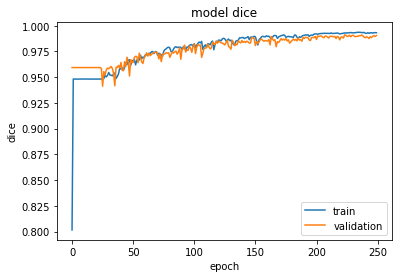

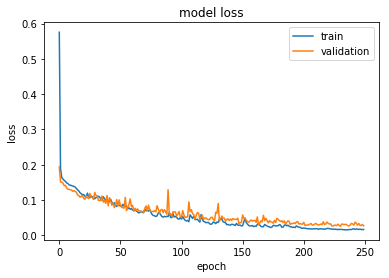

In [7]:
def show_plots(history):
    fig = plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    fig.savefig(os.path.join(save_imgs_dir,"dice-plot.png"))
    
    fig2 = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    fig2.savefig(os.path.join(save_imgs_dir,"loss-plot.png"))
    
show_plots(hist)

In [8]:
import tensorflow as tf

model_endo.load_weights(weight_file)

def calculate_dice(images, masks_true,model_in):
    dices = []
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))

In [9]:
print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_inner_masks,model_endo)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_inner_masks,model_endo)

Training Statistics(No Dropout)...
Dice Average: 0.85 Dice Stdev: 0.20
Validation Statistics(No Dropout)...
Dice Average: 0.74 Dice Stdev: 0.30


# View Predictions on Validation Set

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


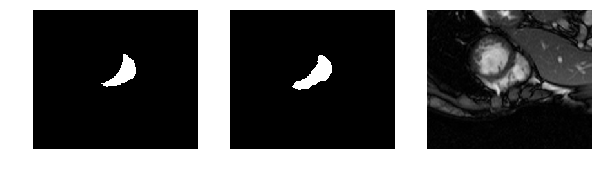

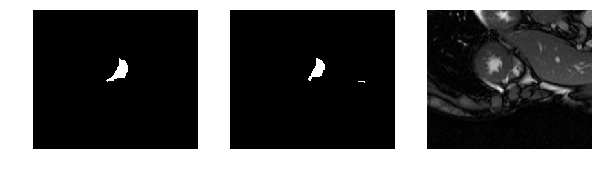

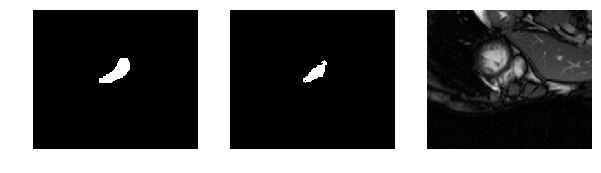

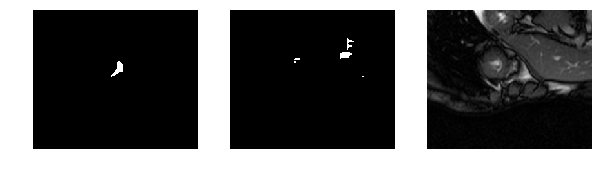

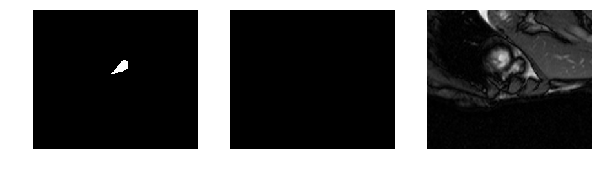

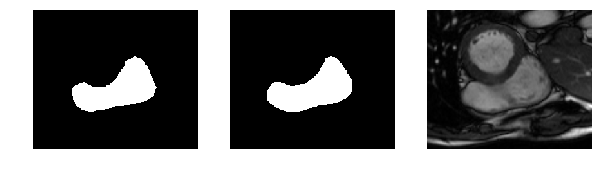

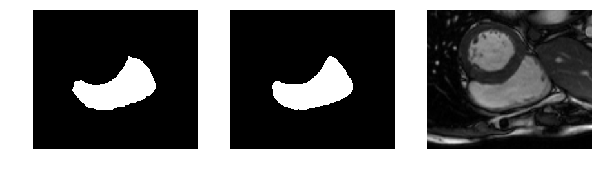

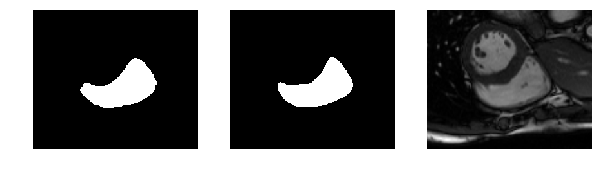

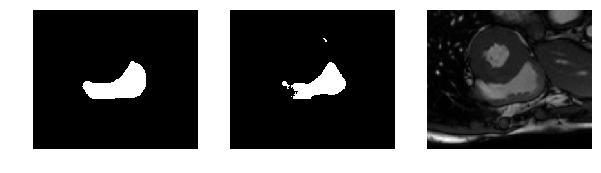

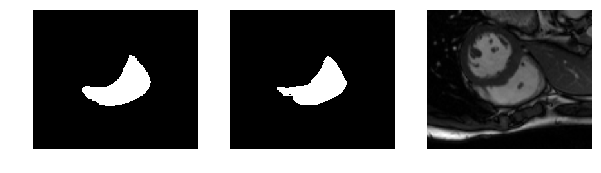

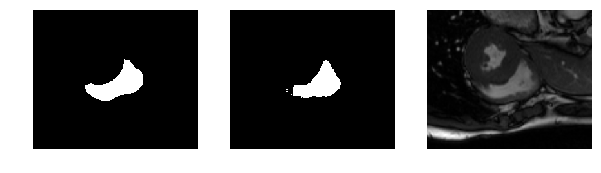

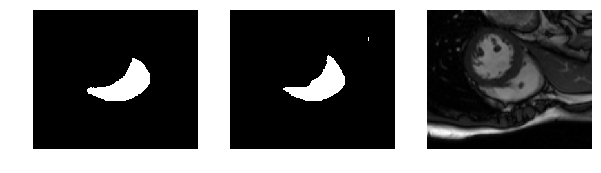

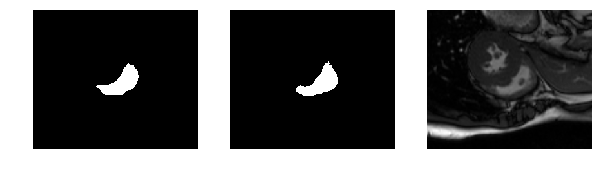

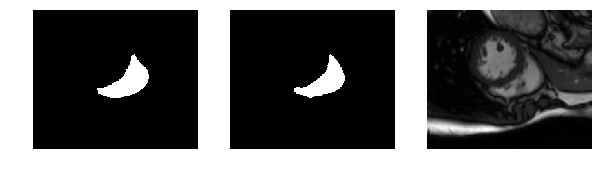

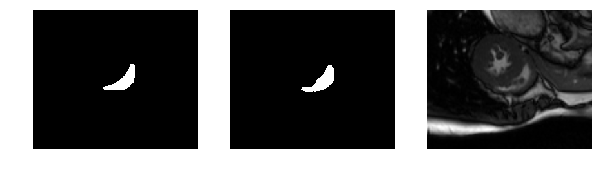

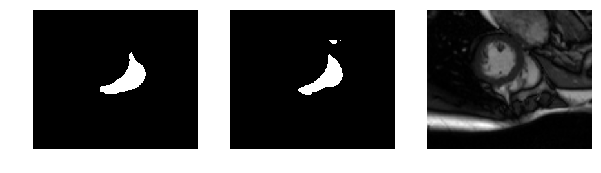

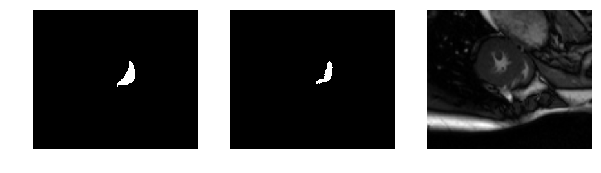

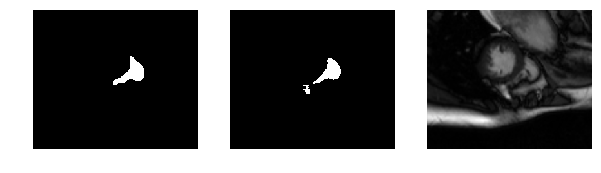

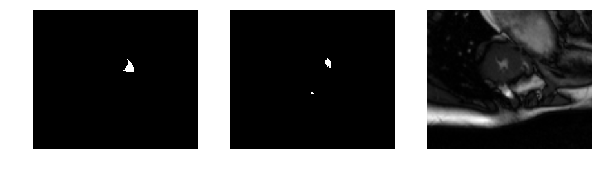

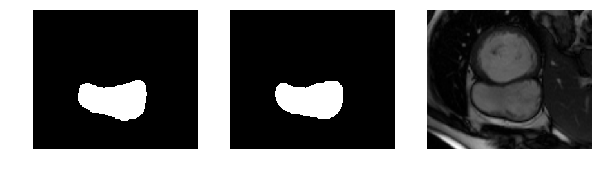

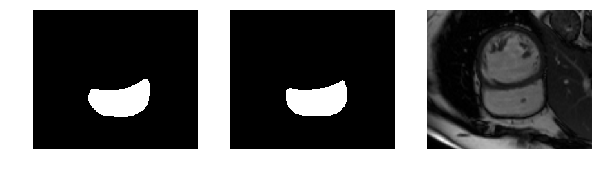

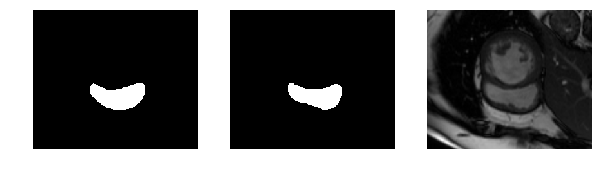

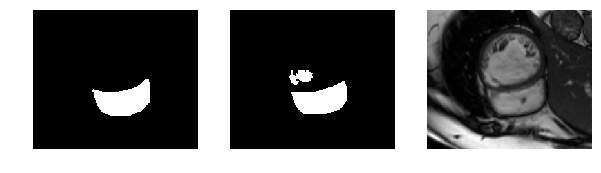

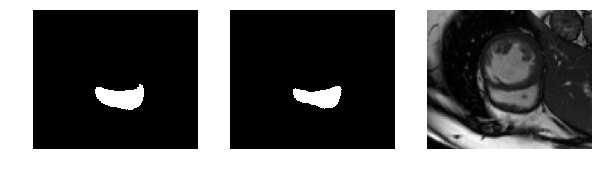

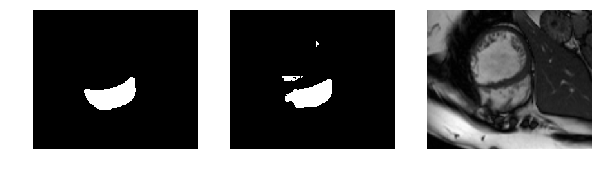

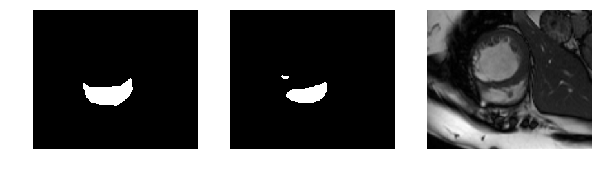

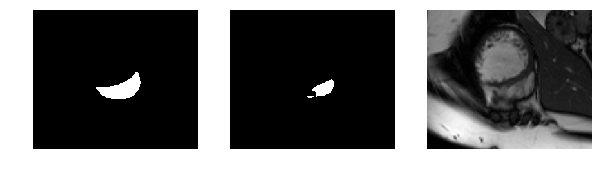

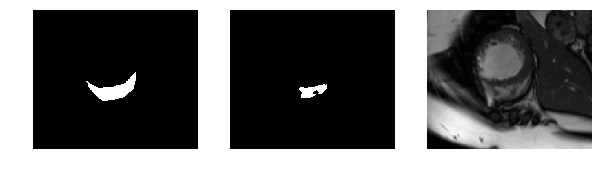

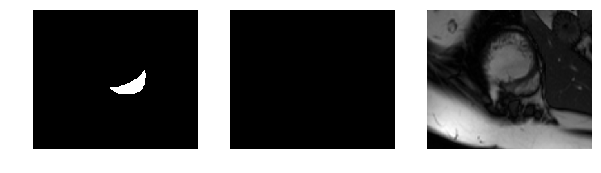

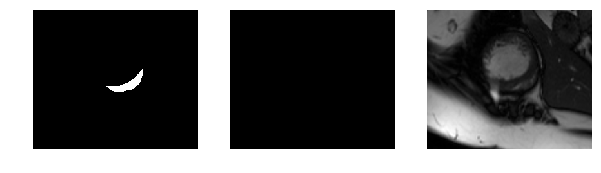

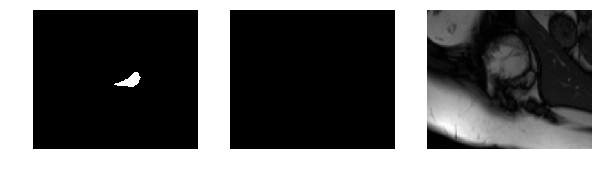

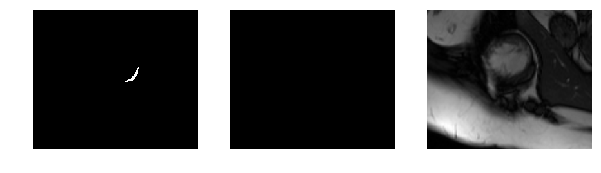

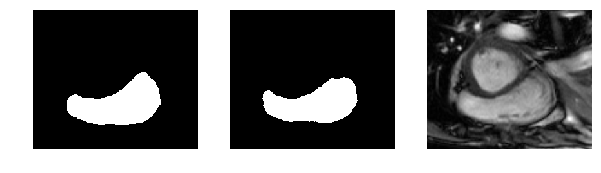

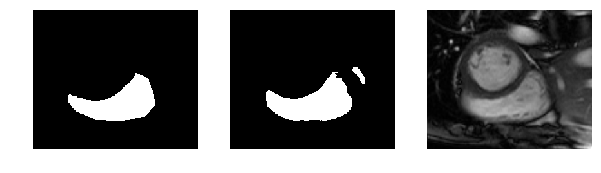

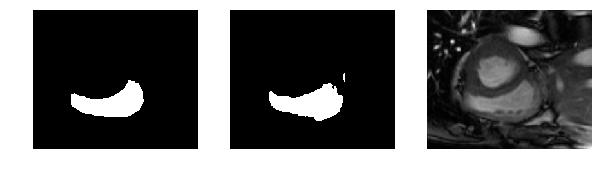

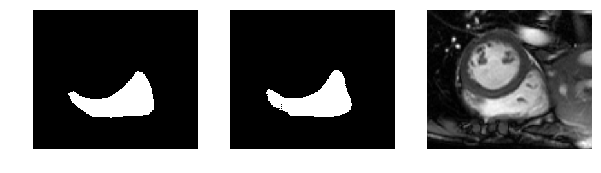

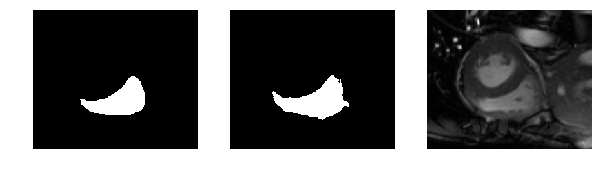

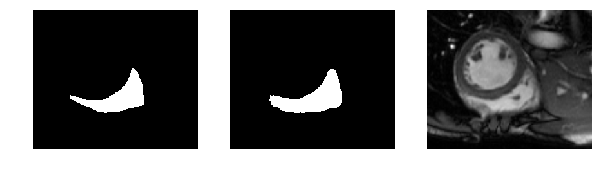

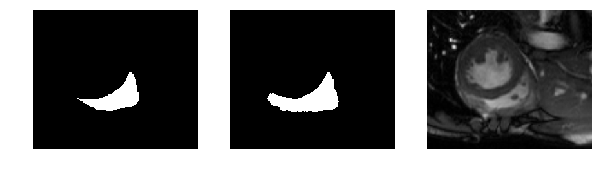

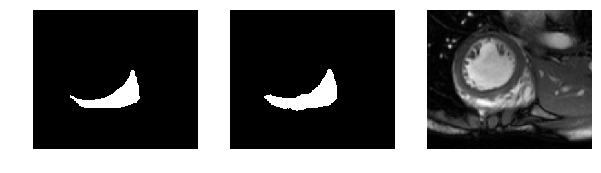

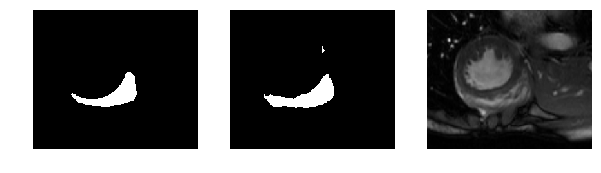

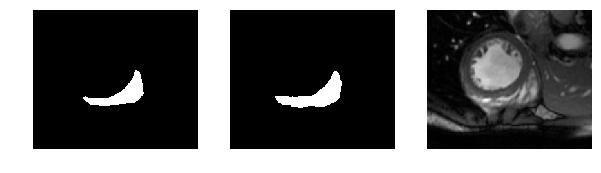

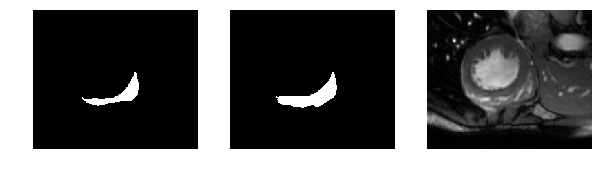

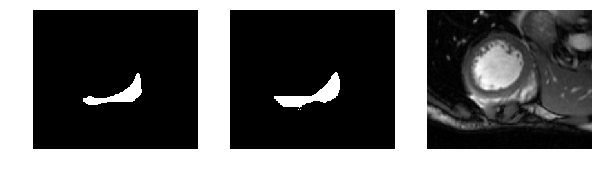

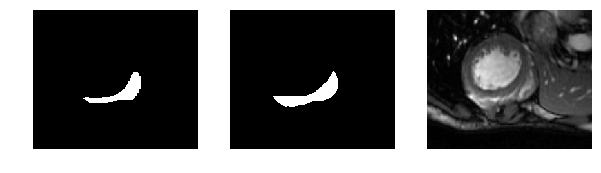

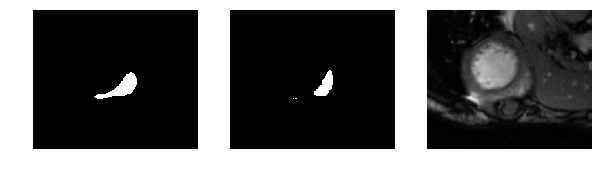

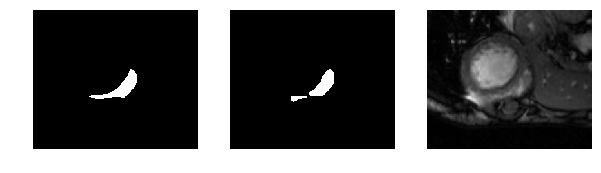

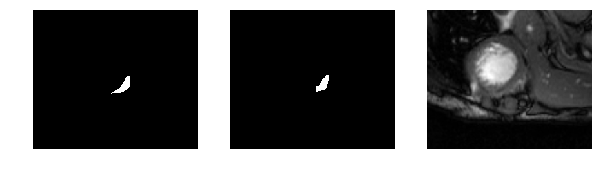

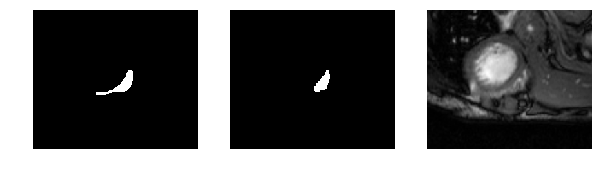

In [10]:
def show_masks(images, i_masks_true,model_in):
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.where(mask_pred[:,:,1]>0.5,255,0),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir, filename))
        
show_masks(images[split_index:], inner_masks[split_index:],model_endo)

# Epicardium Model Training

In [6]:
height,width,_ = images[0].shape
dropout=0.0

unet_conv_epi = unet.UNet()

model_epi = unet_conv_epi.get_unet(height=height, width=width, channels=1,features=32,steps=3,dropout=dropout,padding='same')
model_epi.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 216, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 216, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 216, 256, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 216, 256, 32) 0           activation_16[0][0]              
__________________________________________________________________________________________________
conv2d_17 

In [7]:
model_epi.compile(optimizer=Adam(lr=1e-3),loss=[pixelwise_crossentropy],metrics=[dice_coef])

In [8]:
train_images_datagen.fit(train_images,augment=True,seed=seed)
train_masks_datagen.fit(train_outer_masks,augment=True,seed=seed)

train_images_generator = train_images_datagen.flow(train_images, y=None, seed=seed)
train_masks_generator = train_images_datagen.flow(train_outer_masks, y=None, seed=seed)


train_generator = zip(train_images_generator, train_masks_generator)

/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:722: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).
/usr/local/lib/python3.5/dist-packages/Keras-2.1.3-py3.5.egg/keras/preprocessing/image.py:896: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (194, 216, 256, 2) (2 channels).


In [9]:
checkpointer_epi = ModelCheckpoint(filepath=epi_weight_file, verbose=1, save_best_only=True)

hist_epi = model_epi.fit_generator(train_generator,steps_per_epoch=train_steps,epochs=epochs,verbose=1,callbacks=[checkpointer_epi],
                   validation_data=(validation_images,validation_outer_masks),validation_steps=val_steps)

Epoch 1/250
6/7 [========================>.....] - ETA: 2s - loss: 0.5327 - dice_coef: 0.8044
Epoch 00001: val_loss improved from inf to 0.26238, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 20s 3s/step - loss: 0.4915 - dice_coef: 0.8260 - val_loss: 0.2624 - val_dice_coef: 0.9394
Epoch 2/250
6/7 [========================>.....] - ETA: 1s - loss: 0.2475 - dice_coef: 0.9283
Epoch 00002: val_loss improved from 0.26238 to 0.22071, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 7s 1s/step - loss: 0.2468 - dice_coef: 0.9271 - val_loss: 0.2207 - val_dice_coef: 0.9394
Epoch 3/250
6/7 [========================>.....] - ETA: 1s - loss: 0.2369 - dice_coef: 0.9287
Epoch 00003: val_loss improved from 0.22071 to 0.21569, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 7s 1s/ste

Epoch 27/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1528 - dice_coef: 0.9279
Epoch 00027: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1511 - dice_coef: 0.9307 - val_loss: 0.1502 - val_dice_coef: 0.9394
Epoch 28/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1486 - dice_coef: 0.9277
Epoch 00028: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1385 - dice_coef: 0.9339 - val_loss: 0.1697 - val_dice_coef: 0.9394
Epoch 29/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1511 - dice_coef: 0.9279
Epoch 00029: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1472 - dice_coef: 0.9315 - val_loss: 0.1725 - val_dice_coef: 0.9394
Epoch 30/250
6/7 [========================>.....] - ETA: 1s - loss: 0.1550 - dice_coef: 0.9297
Epoch 00030: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.1554 - dice_coef: 0.9287

6/7 [========================>.....] - ETA: 1s - loss: 0.0767 - dice_coef: 0.9693
Epoch 00085: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0726 - dice_coef: 0.9713 - val_loss: 0.0862 - val_dice_coef: 0.9654
Epoch 86/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0679 - dice_coef: 0.9722
Epoch 00086: val_loss improved from 0.08171 to 0.07728, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.0689 - dice_coef: 0.9718 - val_loss: 0.0773 - val_dice_coef: 0.9701
Epoch 87/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0653 - dice_coef: 0.9743
Epoch 00087: val_loss improved from 0.07728 to 0.07126, saving model to saved_models/epi_models/weights-250Epochs-NoDrop-Adam3-pwloss.hdf5
7/7 [==============================] - 8s 1s/step - loss: 0.0642 - dice_coef: 0.9742 - val_loss: 0.0713 - val_dice_coef: 0.9736
Epoch 88/250
6/7 [==========

Epoch 114/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0618 - dice_coef: 0.9779
Epoch 00114: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0603 - dice_coef: 0.9784 - val_loss: 0.0734 - val_dice_coef: 0.9722
Epoch 115/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0552 - dice_coef: 0.9785
Epoch 00115: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0565 - dice_coef: 0.9779 - val_loss: 0.0661 - val_dice_coef: 0.9745
Epoch 116/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0520 - dice_coef: 0.9803
Epoch 00116: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0600 - dice_coef: 0.9764 - val_loss: 0.0587 - val_dice_coef: 0.9782
Epoch 117/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0607 - dice_coef: 0.9753
Epoch 00117: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0570 - dice_coef: 0.

Epoch 144/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0347 - dice_coef: 0.9865
Epoch 00144: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0345 - dice_coef: 0.9869 - val_loss: 0.0529 - val_dice_coef: 0.9824
Epoch 145/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0319 - dice_coef: 0.9875
Epoch 00145: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0360 - dice_coef: 0.9862 - val_loss: 0.0652 - val_dice_coef: 0.9777
Epoch 146/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0421 - dice_coef: 0.9835
Epoch 00146: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0431 - dice_coef: 0.9833 - val_loss: 0.0488 - val_dice_coef: 0.9826
Epoch 147/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0393 - dice_coef: 0.9847
Epoch 00147: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0388 - dice_coef: 0.

Epoch 175/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0283 - dice_coef: 0.9888
Epoch 00175: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0315 - dice_coef: 0.9871 - val_loss: 0.0448 - val_dice_coef: 0.9839
Epoch 176/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0331 - dice_coef: 0.9869
Epoch 00176: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0322 - dice_coef: 0.9871 - val_loss: 0.0512 - val_dice_coef: 0.9827
Epoch 177/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0346 - dice_coef: 0.9864
Epoch 00177: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0330 - dice_coef: 0.9871 - val_loss: 0.0450 - val_dice_coef: 0.9840
Epoch 178/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0323 - dice_coef: 0.9877
Epoch 00178: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0352 - dice_coef: 0.

Epoch 236/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0261 - dice_coef: 0.9895
Epoch 00236: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0254 - dice_coef: 0.9897 - val_loss: 0.0683 - val_dice_coef: 0.9803
Epoch 237/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0253 - dice_coef: 0.9898
Epoch 00237: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0266 - dice_coef: 0.9891 - val_loss: 0.0452 - val_dice_coef: 0.9839
Epoch 238/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0292 - dice_coef: 0.9885
Epoch 00238: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0278 - dice_coef: 0.9891 - val_loss: 0.0449 - val_dice_coef: 0.9854
Epoch 239/250
6/7 [========================>.....] - ETA: 1s - loss: 0.0258 - dice_coef: 0.9898
Epoch 00239: val_loss did not improve
7/7 [==============================] - 8s 1s/step - loss: 0.0251 - dice_coef: 0.

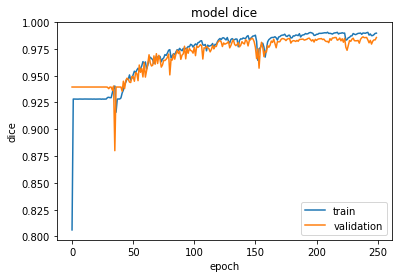

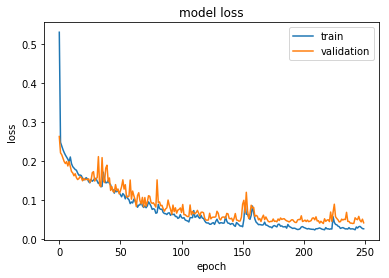

In [10]:
def show_plots(history):
    fig = plt.figure()
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice')
    plt.ylabel('dice')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    fig.savefig(os.path.join(save_imgs_dir_epi,"dice-plot.png"))
    
    fig2 = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    fig2.savefig(os.path.join(save_imgs_dir_epi,"loss-plot.png"))
    
show_plots(hist_epi)

In [11]:
import tensorflow as tf

model_epi.load_weights(epi_weight_file)

def calculate_dice(images, masks_true,model_in):
    dices = []
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        dices.append(dice_coef_np(y_true.flatten(), y_pred.flatten()))
    print("Dice Average: {:.2f} Dice Stdev: {:.2f}".format(np.mean(dices), np.std(dices)))

In [12]:
print("Training Statistics(No Dropout)...")
calculate_dice(train_images, train_outer_masks,model_epi)
print("Validation Statistics(No Dropout)...")
calculate_dice(validation_images, validation_outer_masks,model_epi)

Training Statistics(No Dropout)...
Dice Average: 0.88 Dice Stdev: 0.16
Validation Statistics(No Dropout)...
Dice Average: 0.75 Dice Stdev: 0.30


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


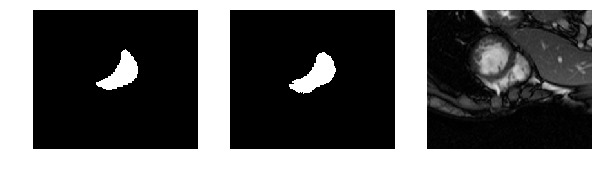

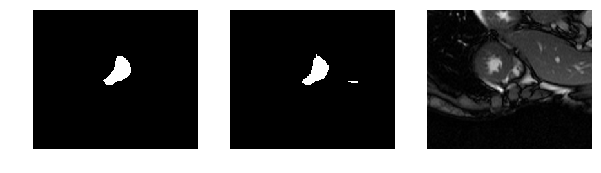

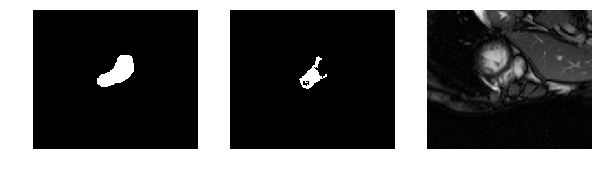

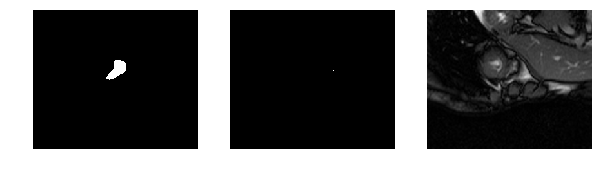

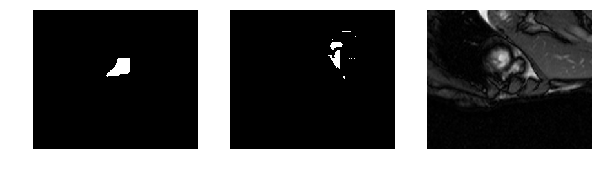

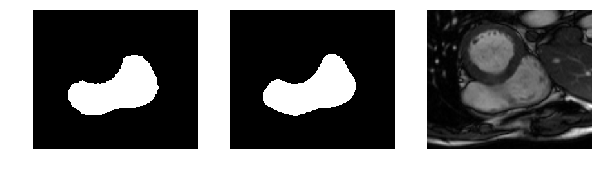

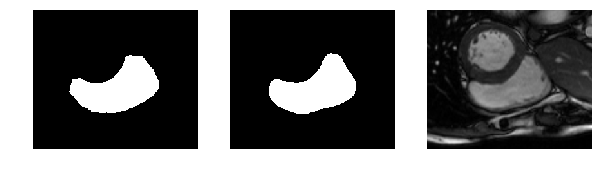

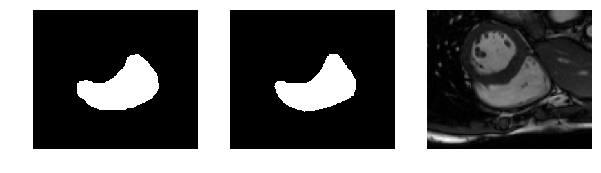

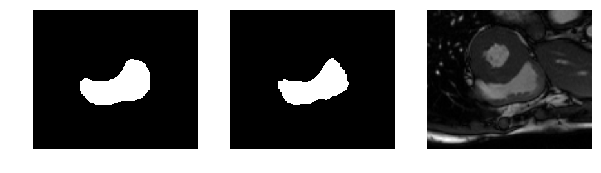

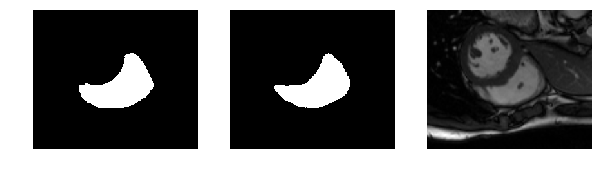

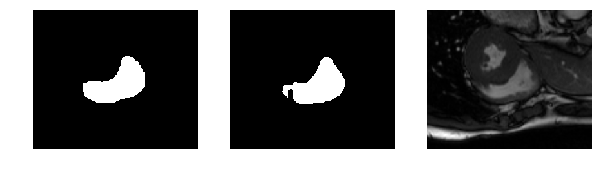

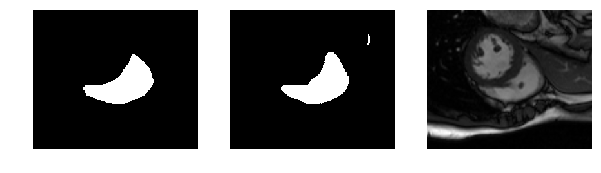

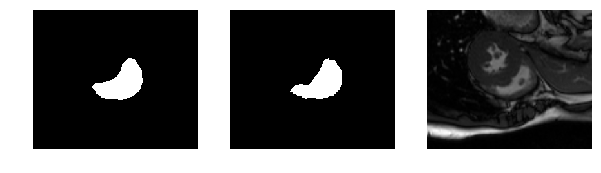

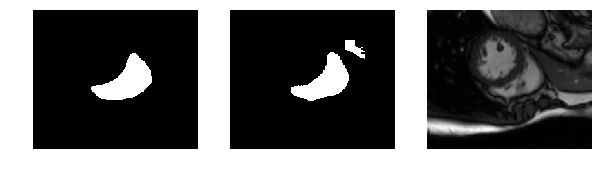

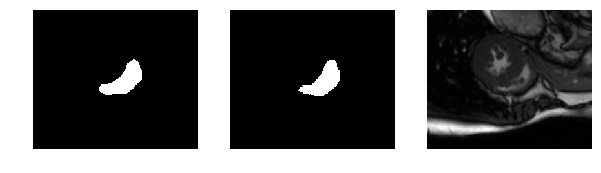

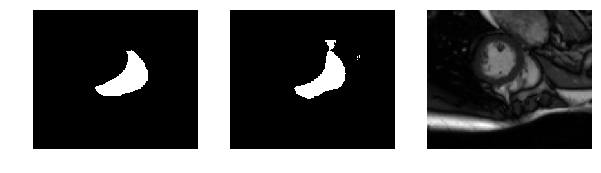

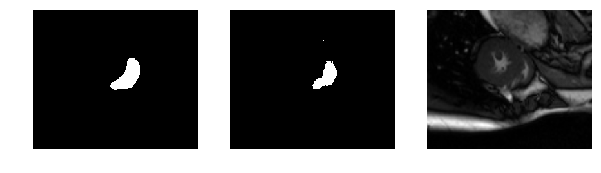

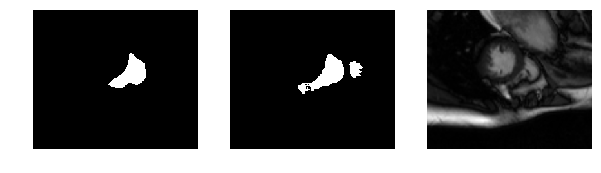

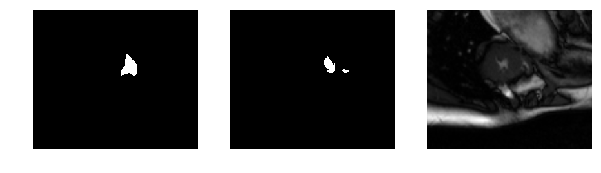

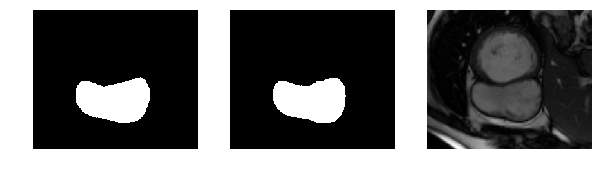

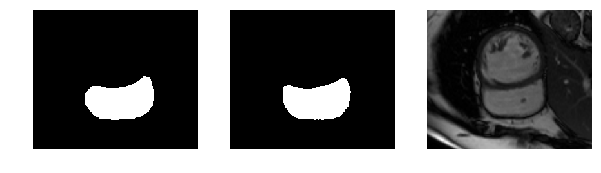

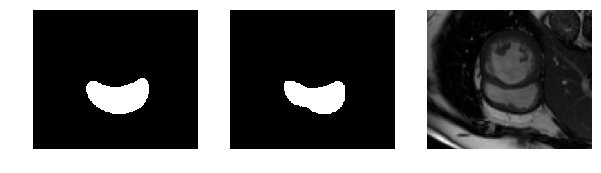

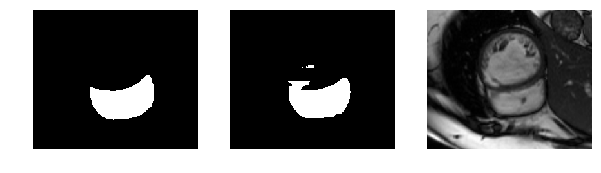

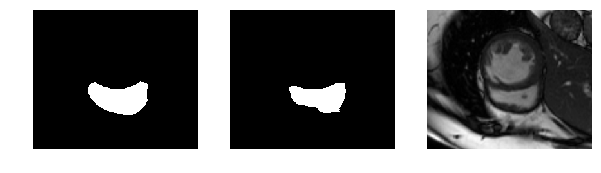

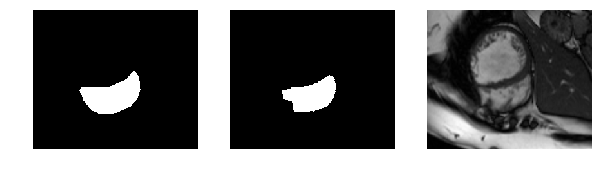

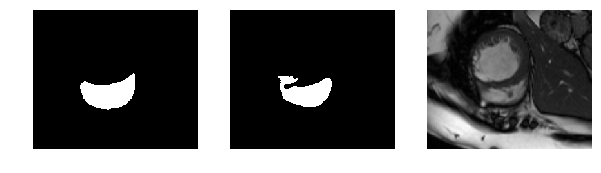

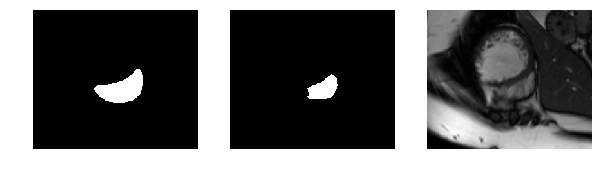

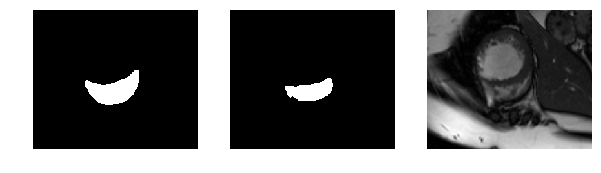

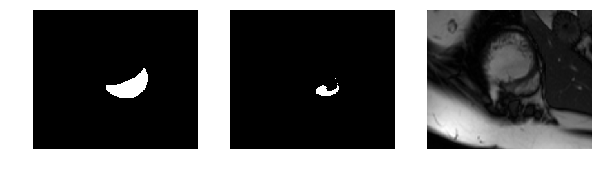

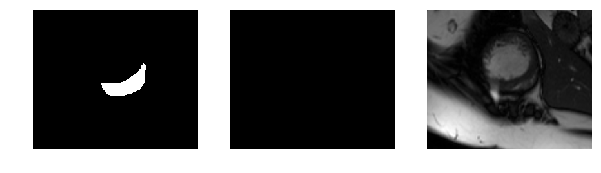

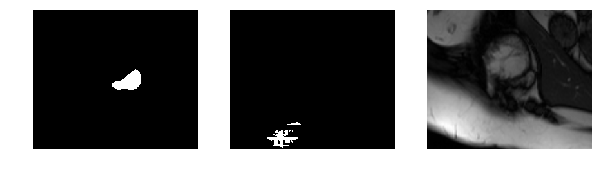

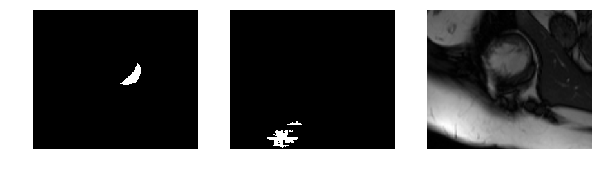

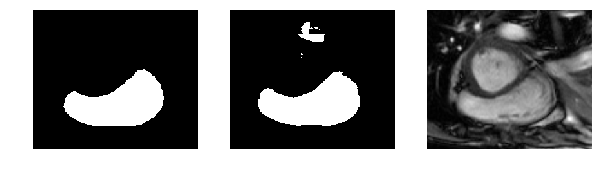

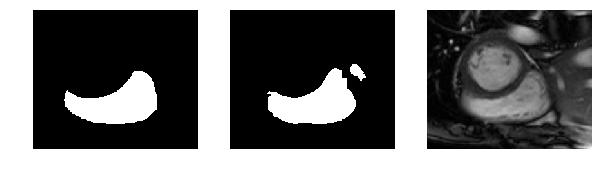

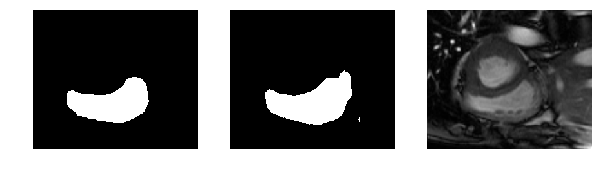

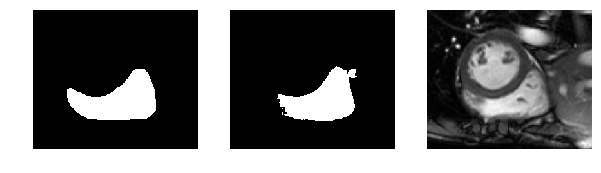

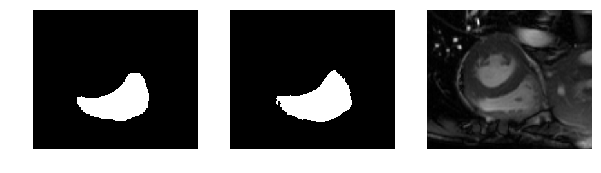

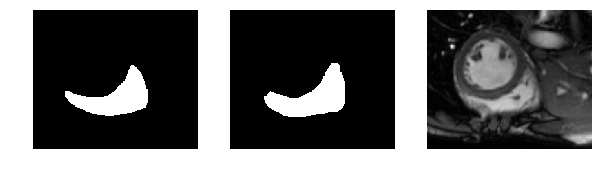

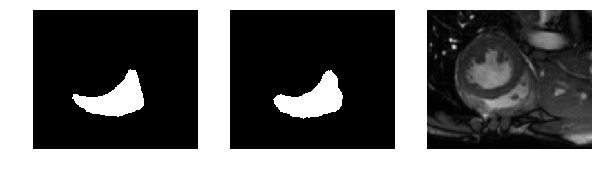

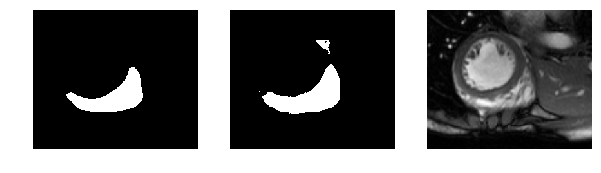

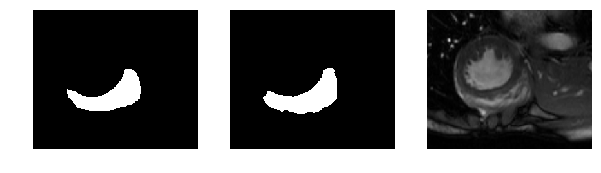

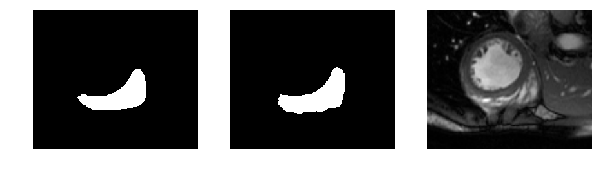

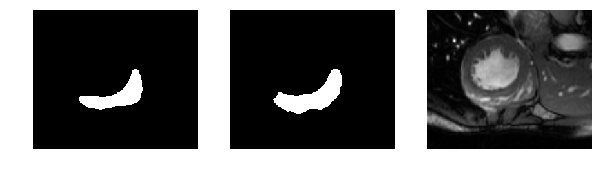

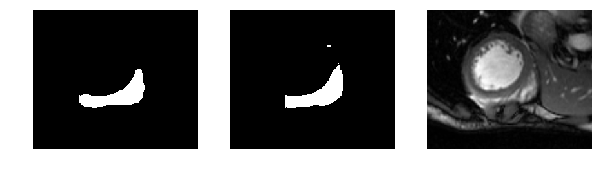

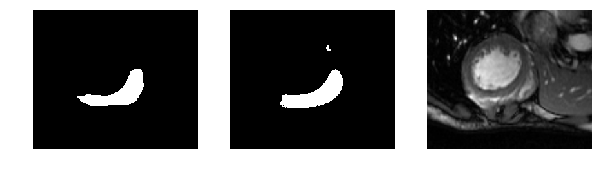

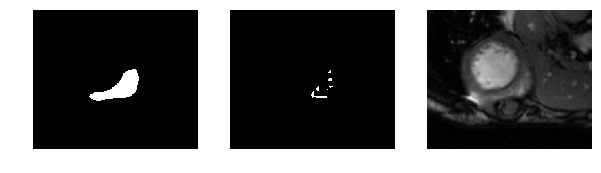

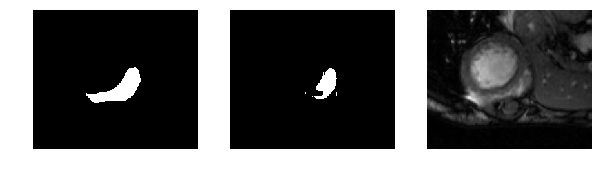

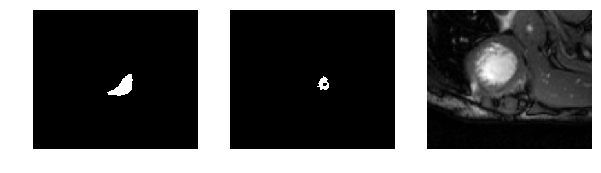

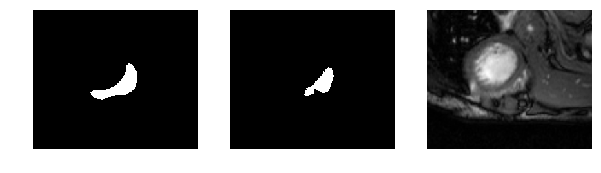

In [13]:
def show_masks(images, i_masks_true,model_in):
    masks_pred = np.concatenate([model_in.predict(image[None,:,:,:]) for image in images])
    counter = 0
    for (image,i_mask,mask_pred) in zip(images,i_masks_true,masks_pred):
        plt.figure(figsize=(10,5))
        plt.subplot(1, 3, 1)
        plt.axis("off")
        plt.imshow(i_mask, cmap=plt.cm.gray)
        plt.subplot(1,3,2)
        plt.axis("off")
        plt.imshow(np.round(mask_pred[:,:,1]),cmap=plt.cm.gray)
        plt.subplot(1, 3, 3)
        plt.axis("off")
        plt.imshow(image[:,:,0], cmap=plt.cm.gray)
        counter += 1
        filename = "{:2d}.png".format(counter)
        plt.savefig(os.path.join(save_imgs_dir_epi, filename))
        
show_masks(images[split_index:], outer_masks[split_index:],model_epi)